C:\Users\neilt\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


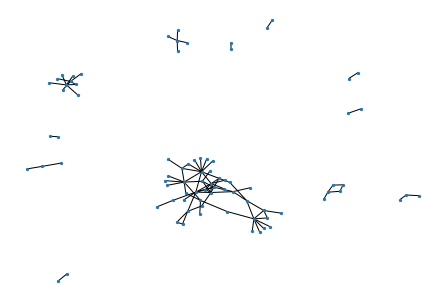

In [1]:
# Import packages
%matplotlib inline
import csv
import networkx as nx

G = nx.Graph()

count1 = 0
count2 = 0
with open('../data/PIRA/CSV/60_PERIOD6_NET.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        count2 = 0
        for col in row:
            if col=='1':
                G.add_edge(count1-1, count2-1)
            count2+=1
        count1+=1


nx.draw(G, node_size=5)

In [2]:
count = -1
with open('../data/PIRA/CSV/60_PERIOD6_ATT.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        
        if row[1]=='0':
            G.nodes[count]['gender'] = 'male'
        elif row[1]=='1':
            G.nodes[count]['gender'] = 'female'
        elif count!=-1:
            G.nodes[count]['gender'] = 'unknown'
            
        if row[2]=='1':
            G.nodes[count]['uni'] = True
        elif row[2]=='0':
            G.nodes[count]['uni'] = False
        elif count!=-1:
            G.nodes[count]['uni'] = 'unknown'
            
        if row[3]=='1':
            G.nodes[count]['married'] = True
        elif row[3]=='0':
            G.nodes[count]['married'] = False
        elif count!=-1:
            G.nodes[count]['married'] = 'unknown'
            
        if row[4]!='99999' and count!=-1:
            G.nodes[count]['rec_age'] = row[4]
        elif count!=-1:
            G.nodes[count]['rec_age'] = 'unknown'
            
        if row[5]=='1':
            G.nodes[count]['brigade'] = 'Antrim'
        elif row[6]=='1':
            G.nodes[count]['brigade'] = 'Derry'
        elif row[7]=='1':
            G.nodes[count]['brigade'] = 'Armagh'
        elif row[8]=='1':
            G.nodes[count]['brigade'] = 'Down'
        elif row[9]=='1':
            G.nodes[count]['brigade'] = 'Tyrone'
        elif row[10]=='1':
            G.nodes[count]['brigade'] = 'Fermanagh'
        elif count!=-1:
            G.nodes[count]['brigade'] = 'unknown'
            
        if row[11]=='1':
            G.nodes[count]['char'] = 'violent'
        elif row[12]=='1':
            G.nodes[count]['char'] = 'non violent'
        elif row[13]=='1':
            G.nodes[count]['char'] = 'violent foreign op'
        elif count!=-1:
            G.nodes[count]['char'] = 'unknown'
        
        if count!=-1:
            G.nodes[count]['role'] = []
        if row[14]=='1':
            G.nodes[count]['role'].append('senior')
        if row[15]=='1':
            G.nodes[count]['role'].append('gunman')
        if row[16]=='1':
            G.nodes[count]['role'].append('ied constructor')
        if row[17]=='1':
            G.nodes[count]['role'].append('ied planter')
        if row[18]=='1':
            G.nodes[count]['role'].append('foreign operation')
        if row[19]=='1':
            G.nodes[count]['role'].append('robbery')

        count+=1

In [3]:
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time

def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.adj[node])) < p
#                 for i in range(len(g.adj[node])):
#                     if success[i]==1:
#                         new_ones.append(list(g.adj[node])[i])
                new_ones += list(np.extract(success, np.array(list(g.adj[node].keys()))))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        #print(np.sort(A))
    return(np.mean(spread))

def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(len(g.nodes()))]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(len(g.nodes())),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(g.nodes())], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):
        
        print("adding node")

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

In [4]:
# Run algorithms
celf_output   = celf(G,20,p = 0.5,mc = 1000)
print("celf output:   " + str(celf_output[0]))

adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
adding node
celf output:   [26, 10, 55, 73, 21, 81, 60, 80, 72, 16, 76, 53, 49, 44, 36, 82, 2, 54, 15, 69]


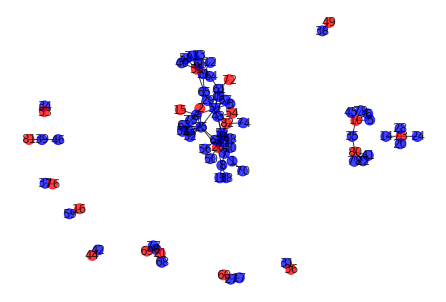

In [5]:
def color(x):
    if x in celf_output[0]:
        return('red')
    else:
        return('blue')
    
nx.draw(G,node_color=[color(x) for x in G.nodes()],alpha=.75, node_size=100, with_labels=True)

In [6]:
for node in celf_output[0]:
    print(G.nodes[node])

{'gender': 'male', 'uni': False, 'married': True, 'rec_age': '21', 'brigade': 'Armagh', 'char': 'violent', 'role': ['ied planter']}
{'gender': 'male', 'uni': False, 'married': True, 'rec_age': '35', 'brigade': 'unknown', 'char': 'non violent', 'role': []}
{'gender': 'male', 'uni': False, 'married': True, 'rec_age': '18', 'brigade': 'unknown', 'char': 'unknown', 'role': ['senior']}
{'gender': 'male', 'uni': False, 'married': 'unknown', 'rec_age': '26', 'brigade': 'unknown', 'char': 'violent', 'role': ['gunman']}
{'gender': 'male', 'uni': False, 'married': 'unknown', 'rec_age': '22', 'brigade': 'Armagh', 'char': 'violent', 'role': ['gunman']}
{'gender': 'male', 'uni': False, 'married': 'unknown', 'rec_age': '26', 'brigade': 'unknown', 'char': 'violent', 'role': ['ied planter', 'foreign operation']}
{'gender': 'male', 'uni': False, 'married': 'unknown', 'rec_age': '23', 'brigade': 'unknown', 'char': 'unknown', 'role': []}
{'gender': 'male', 'uni': False, 'married': True, 'rec_age': '25', 

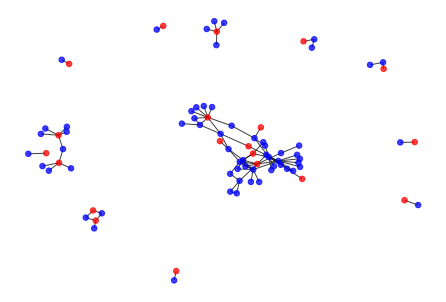

In [7]:
def color(x):
    if x in celf_output[0]:
        return('red')
    else:
        return('blue')
    
nx.draw(G,node_color=[color(x) for x in G.nodes()],alpha=.75, node_size=30)

In [8]:
import numpy as np

p0_male = len([node for node in G.nodes() if G.nodes[node]['gender']=='male'])/count
p0_female = len([node for node in G.nodes() if G.nodes[node]['gender']=='female'])/count
p0_ukn = len([node for node in G.nodes() if G.nodes[node]['gender']=='unknown'])/count
p0_uni = len([node for node in G.nodes() if G.nodes[node]['uni']==True])/count
p0_nouni = len([node for node in G.nodes() if G.nodes[node]['uni']==False])/count
p0_uniukn = len([node for node in G.nodes() if G.nodes[node]['uni']=='unknown'])/count
p0_mar = len([node for node in G.nodes() if G.nodes[node]['married']==True])/count
p0_nomar = len([node for node in G.nodes() if G.nodes[node]['married']==False])/count
p0_marukn = len([node for node in G.nodes() if G.nodes[node]['married']=='unknown'])/count
p0_vio = len([node for node in G.nodes() if G.nodes[node]['char']=='violent'])/count + len([node for node in G.nodes() if G.nodes[node]['char']=='violent foreign op'])/count
p0_novio = len([node for node in G.nodes() if G.nodes[node]['char']=='non violent'])/count
p0_charukn = len([node for node in G.nodes() if G.nodes[node]['char']=='unknown'])/count
p0_senior = len([node for node in G.nodes() if 'senior' in G.nodes[node]['role']])/count
p0_gm = len([node for node in G.nodes() if 'gunman' in G.nodes[node]['role']])/count
p0_ied = len([node for node in G.nodes() if 'ied constructor' in G.nodes[node]['role']])/count + len([node for node in G.nodes() if 'ied planter' in G.nodes[node]['role']])/count
p0_rob = len([node for node in G.nodes() if 'robbery' in G.nodes[node]['role']])/count
p0_fops = len([node for node in G.nodes() if 'foreign operation' in G.nodes[node]['role']])/count
p0_roleukn = len([node for node in G.nodes() if len(G.nodes[node]['role'])==0])/count


print("male: ",p0_male)
print("female: ",p0_female)
print("gender unknown: ",p0_ukn)
print("\n")

print("university: ",p0_uni)
print("no university: ",p0_nouni)
print("university unknown: ",p0_uniukn)
print("\n")

print("married: ",p0_mar)
print("not married: ",p0_nomar)
print("married unknown: ",p0_marukn)
print("\n")

print("violent: ",p0_vio)
print("non violent: ",p0_novio)
print("character unknown: ",p0_charukn)
print("\n")

print("Average recruitment age: ", sum([int(G.nodes[node]['rec_age']) for node in G.nodes() if G.nodes[node]['rec_age']!='unknown'])/len([int(G.nodes[node]['rec_age']) for node in G.nodes() if G.nodes[node]['rec_age']!='unknown']))
print("Standard deviation in recruitment age: ", np.std([int(G.nodes[node]['rec_age']) for node in G.nodes() if G.nodes[node]['rec_age']!='unknown']))
print("unknown recruitment age: ", len([node for node in G.nodes() if G.nodes[node]['rec_age']=='unknown'])/count)
print("\n")

print("senior: ",p0_senior)
print("gun man: ",p0_gm)
print("ied: ",p0_ied)
print("foreign ops: ",p0_fops)
print("robbery: ",p0_rob)
print("unknown role: ",p0_roleukn)
print("\n")

print(count)

male:  0.9397590361445783
female:  0.060240963855421686
gender unknown:  0.0


university:  0.03614457831325301
no university:  0.963855421686747
university unknown:  0.0


married:  0.39759036144578314
not married:  0.13253012048192772
married unknown:  0.46987951807228917


violent:  0.40963855421686746
non violent:  0.07228915662650602
character unknown:  0.5180722891566265


Average recruitment age:  24.796875
Standard deviation in recruitment age:  6.724906336475996
unknown recruitment age:  0.2289156626506024


senior:  0.03614457831325301
gun man:  0.1927710843373494
ied:  0.2891566265060241
foreign ops:  0.12048192771084337
robbery:  0.10843373493975904
unknown role:  0.5060240963855421


83


In [9]:
p_male = len([node for node in celf_output[0] if G.nodes[node]['gender']=='male'])/len(celf_output[0])
p_female = len([node for node in celf_output[0] if G.nodes[node]['gender']=='female'])/len(celf_output[0])
p_ukn = len([node for node in celf_output[0] if G.nodes[node]['gender']=='unknown'])/len(celf_output[0])
p_uni = len([node for node in celf_output[0] if G.nodes[node]['uni']==True])/len(celf_output[0])
p_nouni = len([node for node in celf_output[0] if G.nodes[node]['uni']==False])/len(celf_output[0])
p_uniukn = len([node for node in celf_output[0] if G.nodes[node]['uni']=='unknown'])/len(celf_output[0])
p_mar = len([node for node in celf_output[0] if G.nodes[node]['married']==True])/len(celf_output[0])
p_nomar = len([node for node in celf_output[0] if G.nodes[node]['married']==False])/len(celf_output[0])
p_marukn = len([node for node in celf_output[0] if G.nodes[node]['married']=='unknown'])/len(celf_output[0])
p_vio = len([node for node in celf_output[0] if G.nodes[node]['char']=='violent'])/len(celf_output[0]) + len([node for node in celf_output[0] if G.nodes[node]['char']=='violent foreign op'])/len(celf_output[0])
p_novio = len([node for node in celf_output[0] if G.nodes[node]['char']=='non violent'])/len(celf_output[0])
p_charukn = len([node for node in celf_output[0] if G.nodes[node]['char']=='unknown'])/len(celf_output[0])
p_senior = len([node for node in celf_output[0] if 'senior' in G.nodes[node]['role']])/len(celf_output[0])
p_gm = len([node for node in celf_output[0] if 'gunman' in G.nodes[node]['role']])/len(celf_output[0])
p_ied = len([node for node in celf_output[0] if 'ied constructor' in G.nodes[node]['role']])/len(celf_output[0]) + len([node for node in celf_output[0] if 'ied planter' in G.nodes[node]['role']])/len(celf_output[0])
p_rob = len([node for node in celf_output[0] if 'robbery' in G.nodes[node]['role']])/len(celf_output[0])
p_fops = len([node for node in celf_output[0] if 'foreign operation' in G.nodes[node]['role']])/len(celf_output[0])
p_roleukn = len([node for node in celf_output[0] if len(G.nodes[node]['role'])==0])/len(celf_output[0])

print("male: ",p_male)
print("female: ",p_female)
print("gender unknown: ",p_ukn)
print("\n")

print("university: ",p_uni)
print("no university: ",p_nouni)
print("university unknown: ",p_uniukn)
print("\n")

print("married: ",p_mar)
print("not married: ",p_nomar)
print("married unknown: ",p_marukn)
print("\n")

print("violent: ",p_vio)
print("non violent: ",p_novio)
print("character unknown: ",p_charukn)
print("\n")

print("senior: ",p_senior)
print("gun man: ",p_gm)
print("ied: ",p_ied)
print("foreign ops: ",p_fops)
print("robbery: ",p_rob)
print("unknown role: ",p_roleukn)
print("\n")

print("Average recruitment age: ", sum([int(G.nodes[node]['rec_age']) for node in celf_output[0] if G.nodes[node]['rec_age']!='unknown'])/len([int(G.nodes[node]['rec_age']) for node in celf_output[0] if G.nodes[node]['rec_age']!='unknown']))
print("unknown recruitment age: ", len([node for node in celf_output[0] if G.nodes[node]['rec_age']=='unknown'])/len(celf_output[0]))
print("\n")

male:  1.0
female:  0.0
gender unknown:  0.0


university:  0.0
no university:  1.0
university unknown:  0.0


married:  0.4
not married:  0.05
married unknown:  0.55


violent:  0.5
non violent:  0.1
character unknown:  0.4


senior:  0.05
gun man:  0.2
ied:  0.30000000000000004
foreign ops:  0.05
robbery:  0.05
unknown role:  0.45


Average recruitment age:  23.5
unknown recruitment age:  0.1




In [10]:
z_male = (p_male-p0_male)/np.sqrt(p0_male*(1-p0_male)/len(G.nodes()))
z_female = (p_female-p0_female)/np.sqrt(p0_female*(1-p0_female)/len(G.nodes()))
z_uni = (p_uni-p0_uni)/np.sqrt(p0_uni*(1-p0_uni)/len(G.nodes()))
z_nouni = (p_nouni-p0_nouni)/np.sqrt(p0_nouni*(1-p0_nouni)/len(G.nodes()))
z_mar = (p_mar-p0_mar)/np.sqrt(p0_mar*(1-p0_mar)/len(G.nodes()))
z_nomar = (p_nomar-p0_nomar)/np.sqrt(p0_nomar*(1-p0_nomar)/len(G.nodes()))
z_marukn = (p_marukn-p0_marukn)/np.sqrt(p0_marukn*(1-p0_marukn)/len(G.nodes()))
z_vio = (p_vio-p0_vio)/np.sqrt(p0_vio*(1-p0_vio)/len(G.nodes()))
z_novio = (p_novio-p0_novio)/np.sqrt(p0_novio*(1-p0_novio)/len(G.nodes()))
z_charukn = (p_charukn-p0_charukn)/np.sqrt(p0_charukn*(1-p0_charukn)/len(G.nodes()))
z_senior = (p_senior-p0_senior)/np.sqrt(p0_senior*(1-p0_senior)/len(G.nodes()))
z_gm = (p_gm-p0_gm)/np.sqrt(p0_gm*(1-p0_gm)/len(G.nodes()))
z_ied = (p_ied-p0_ied)/np.sqrt(p0_ied*(1-p0_ied)/len(G.nodes()))
z_rob = (p_rob-p0_rob)/np.sqrt(p0_rob*(1-p0_rob)/len(G.nodes()))
z_fops = (p_fops-p0_fops)/np.sqrt(p0_fops*(1-p0_fops)/len(G.nodes()))
z_roleukn = (p_roleukn-p0_roleukn)/np.sqrt(p0_roleukn*(1-p0_roleukn)/len(G.nodes()))

In [11]:
import scipy.stats

pv_male = scipy.stats.norm.sf(abs(z_male))*2
pv_female = scipy.stats.norm.sf(abs(z_female))*2
pv_uni = scipy.stats.norm.sf(abs(z_uni))*2
pv_nouni = scipy.stats.norm.sf(abs(z_nouni))*2
pv_mar = scipy.stats.norm.sf(abs(z_mar))*2
pv_nomar = scipy.stats.norm.sf(abs(z_nomar))*2
pv_marukn = scipy.stats.norm.sf(abs(z_marukn))*2
pv_vio = scipy.stats.norm.sf(abs(z_vio))*2
pv_novio = scipy.stats.norm.sf(abs(z_novio))*2
pv_charukn = scipy.stats.norm.sf(abs(z_charukn))*2
pv_senior = scipy.stats.norm.sf(abs(z_senior))*2
pv_gm = scipy.stats.norm.sf(abs(z_gm))*2
pv_ied = scipy.stats.norm.sf(abs(z_ied))*2
pv_rob = scipy.stats.norm.sf(abs(z_rob))*2
pv_fops = scipy.stats.norm.sf(abs(z_fops))*2
pv_roleukn = scipy.stats.norm.sf(abs(z_roleukn))*2

print("male: ",pv_male)
print("female: ",pv_female)
print("\n")

print("university: ",pv_uni)
print("no university: ",pv_nouni)
print("\n")

print("married: ",pv_mar)
print("not married: ",pv_nomar)
print("married unknown: ",pv_marukn)
print("\n")

print("violent: ",pv_vio)
print("non violent: ",pv_novio)
print("character unknown: ",pv_charukn)
print("\n")

print("senior: ",pv_senior)
print("gun man: ",pv_gm)
print("ied: ",pv_ied)
print("foreign ops: ",pv_fops)
print("robbery: ",pv_rob)
print("unknown role: ",pv_roleukn)
print("\n")

male:  0.021075808025449873
female:  0.021075808025449824


university:  0.07769362119007382
no university:  0.07769362119007382


married:  0.9642215511109453
not married:  0.026587758634264363
married unknown:  0.14359855023740883


violent:  0.0941250259337237
non violent:  0.32962565258463616
character unknown:  0.031335486126583455


senior:  0.4988582210543172
gun man:  0.8674074306670463
ied:  0.8275098814431685
foreign ops:  0.04854402561782445
robbery:  0.08686767801961008
unknown role:  0.3073104828747867




In [12]:
print(celf_output[1])

[21.416, 25.631, 29.191, 32.203, 35.213, 37.251, 39.289, 41.324, 43.123, 44.642, 46.161, 47.68, 49.199, 50.718, 52.237, 53.215, 54.074, 54.874, 55.648, 56.398]
